In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import glob
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
from scipy.linalg import toeplitz
from patsy import dmatrices
from math import sqrt
sns.set_style('white')

In [2]:
filename_2019 = glob.glob('../data/2019/*.csv')
filename_2019.sort()
filename_2019

['../data/2019/agm.csv',
 '../data/2019/alm.csv',
 '../data/2019/bum.csv',
 '../data/2019/cfm.csv',
 '../data/2019/cum.csv',
 '../data/2019/ebm.csv',
 '../data/2019/egm.csv',
 '../data/2019/hcm.csv',
 '../data/2019/im.csv',
 '../data/2019/jm.csv',
 '../data/2019/jmm.csv',
 '../data/2019/lm.csv',
 '../data/2019/mam.csv',
 '../data/2019/nim.csv',
 '../data/2019/oim.csv',
 '../data/2019/pbm.csv',
 '../data/2019/ppm.csv',
 '../data/2019/rbm.csv',
 '../data/2019/rum.csv',
 '../data/2019/smm.csv',
 '../data/2019/snm.csv',
 '../data/2019/srm.csv',
 '../data/2019/tam.csv',
 '../data/2019/vm.csv',
 '../data/2019/znm.csv']

In [3]:
df = pd.read_csv(filename_2019[0], index_col=0, encoding='gbk')
df.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open interest']
df.rename_axis("type", axis='index', inplace=True)
df['time'] = pd.to_datetime(df['time'])

df.reset_index(inplace=True)
df

,type,code,time,open,high,low,close,volume,turnover,open interest
0,SC,ag1906,2019-01-02 09:01:00,3700.0,3700.0,3689.0,3693.0,16680.0,924595320.0,704740
1,SC,ag1906,2019-01-02 09:02:00,3693.0,3695.0,3693.0,3694.0,5184.0,287231490.0,704034
2,SC,ag1906,2019-01-02 09:03:00,3693.0,3694.0,3688.0,3690.0,5782.0,320071080.0,703846
3,SC,ag1906,2019-01-02 09:04:00,3690.0,3692.0,3689.0,3692.0,3100.0,171616620.0,703254
4,SC,ag1906,2019-01-02 09:05:00,3691.0,3693.0,3691.0,3692.0,2184.0,120945390.0,702870
...,...,...,...,...,...,...,...,...,...,...
133105,SC,ag2002,2019-12-31 14:56:00,4385.0,4386.0,4384.0,4385.0,4026.0,264795480.0,392150
133106,SC,ag2002,2019-12-31 14:57:00,4385.0,4386.0,4383.0,4384.0,4526.0,297656190.0,391580
133107,SC,ag2002,2019-12-31 14:58:00,4384.0,4387.0,4383.0,4387.0,5064.0,333129450.0,390390
133108,SC,ag2002,2019-12-31 14:59:00,4388.0,4388.0,4386.0,4386.0,3570.0,234917340.0,389040


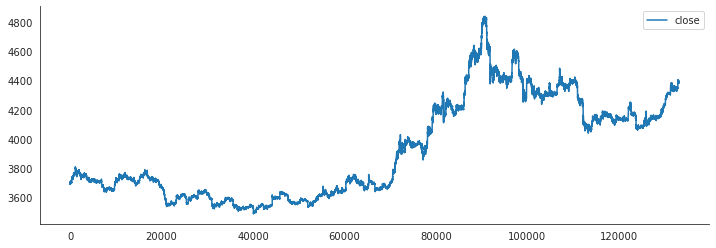

In [4]:
df[['close']].plot(grid=False, figsize=(12,4))
sns.despine()

In [5]:
times = []
for i in range(5, 121, 5):
    df[f'return_{i}_minutes'] = df['close'].shift(-i) - df['close']
    times.append(f'return_{i}_minutes')

In [6]:
times

['return_5_minutes',
 'return_10_minutes',
 'return_15_minutes',
 'return_20_minutes',
 'return_25_minutes',
 'return_30_minutes',
 'return_35_minutes',
 'return_40_minutes',
 'return_45_minutes',
 'return_50_minutes',
 'return_55_minutes',
 'return_60_minutes',
 'return_65_minutes',
 'return_70_minutes',
 'return_75_minutes',
 'return_80_minutes',
 'return_85_minutes',
 'return_90_minutes',
 'return_95_minutes',
 'return_100_minutes',
 'return_105_minutes',
 'return_110_minutes',
 'return_115_minutes',
 'return_120_minutes']

In [7]:
# Drop NaN
df.drop(df.tail(120).index,inplace=True) 

In [8]:
short_period = [2, 3, 4, 6, 8, 10, 12, 14, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]
long_period = (np.array(short_period) * 4).tolist()
window_index = []
window_index_to_window = {}
long_period
for i in range(len(short_period)):
    window_index.append(f'{short_period[i]}-{long_period[i]}')
    
    window_index_to_window[f'{short_period[i]}-{long_period[i]}'] = [short_period[i], long_period[i]]
window_index

['2-8',
 '3-12',
 '4-16',
 '6-24',
 '8-32',
 '10-40',
 '12-48',
 '14-56',
 '16-64',
 '20-80',
 '24-96',
 '28-112',
 '32-128',
 '36-144',
 '40-160',
 '44-176',
 '48-192',
 '52-208',
 '56-224',
 '60-240',
 '64-256']

In [9]:
window_index_to_window

{'2-8': [2, 8],
 '3-12': [3, 12],
 '4-16': [4, 16],
 '6-24': [6, 24],
 '8-32': [8, 32],
 '10-40': [10, 40],
 '12-48': [12, 48],
 '14-56': [14, 56],
 '16-64': [16, 64],
 '20-80': [20, 80],
 '24-96': [24, 96],
 '28-112': [28, 112],
 '32-128': [32, 128],
 '36-144': [36, 144],
 '40-160': [40, 160],
 '44-176': [44, 176],
 '48-192': [48, 192],
 '52-208': [52, 208],
 '56-224': [56, 224],
 '60-240': [60, 240],
 '64-256': [64, 256]}

In [10]:
def calculate_hull_moving_average(df, period):

    df['window_t_ewm'] = df['close'].ewm(span=period).mean()
    df['window_half_ewm'] = df['close'].ewm(span=period/2).mean()
    df['diff']=df['window_half_ewm'] * 2 - df['window_t_ewm']
    
    df[f'hma{period}']=df['diff'].ewm(span=int(math.sqrt(period))).mean()
    
    irrelevant_col = ['window_t_ewm', 'window_half_ewm', 'diff']
    df.drop(columns=irrelevant_col, inplace = True)
    
calculate_hull_moving_average(df, short_period[2])
calculate_hull_moving_average(df, long_period[2])

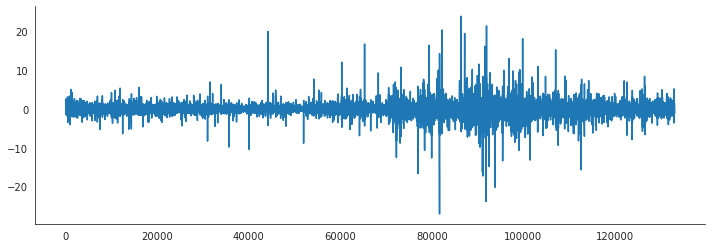

In [11]:
df['short_long_diff'] = df[f'hma{short_period[2]}'] - df[f'hma{long_period[2]}']

short_long_diff_std = df['short_long_diff'].std()

df['momentum'] = df['short_long_diff'] / short_long_diff_std

df['momentum'].plot(grid=False, figsize=(12,4))
sns.despine()

In [12]:
X2 = sm.add_constant(df['momentum'])
est = sm.OLS(df['return_5_minutes'], X2, missing='drop')
results = est.fit()
print(results.summary())
print("Parameters: ", results.params['momentum'])
print("P Values: ", results.pvalues)

                            OLS Regression Results                            
Dep. Variable:       return_5_minutes   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     192.7
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           8.86e-44
Time:                        21:17:20   Log-Likelihood:            -3.7828e+05
No. Observations:              132990   AIC:                         7.566e+05
Df Residuals:                  132988   BIC:                         7.566e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0267      0.011      2.342      0.0

In [13]:
threshold = [0, 0.1, 0.25, 0.5, 0.75, 1, 2]

In [14]:
def calculate_future_return(data):
    for i in range(5, 121, 5):
        data[f'return_{i}_minutes'] = data['close'].shift(-i) - data['close']
    # Drop NaN
    data.drop(data.tail(120).index,inplace=True) 

In [15]:
def calculate_momentum(data, short_period, long_period, hma=True):
    if (hma):
        calculate_hull_moving_average(data, short_period)
        calculate_hull_moving_average(data, long_period)
        data['short_long_diff'] = data[f'hma{short_period}'] - data[f'hma{long_period}']
        short_long_diff_std = data['short_long_diff'].std()
        data['momentum'] = data['short_long_diff'] / short_long_diff_std
        
        used_col = ['short_long_diff', f'hma{short_period}', f'hma{long_period}']
        data.drop(columns=used_col, inplace = True)
        
    else:
        data['short_ewm'] = data['close'].ewm(span=short_period).mean()
        data['long_ewm'] = data['close'].ewm(span=long_period).mean()
        data['short_long_diff'] = data['short_ewm'] - data['long_ewm']
        short_long_diff_std = data['short_long_diff'].std()
        data['momentum'] = data['short_long_diff'] / short_long_diff_std
        
        used_col = ['short_long_diff', data['short_ewm'], data['short_ewm']]
        data.drop(columns=used_col, inplace = True)

In [16]:
def linear_regression_parameters_of_momentum(data, time = 'one_minute_return'):
    X2 = sm.add_constant(data['momentum'])
    est = sm.OLS(data[time], X2, missing='drop')
    results = est.fit()
    # print(results.summary())
    parameter = results.params['momentum']
    r_square = results.rsquared
    
    return parameter, r_square

沪银主力（AGM），表格Index为均线Window长度（short-long），Column为Return Time Window

In [17]:
# print(filename_2019[1])
# data = pd.read_csv(filename_2019[1], index_col=0, encoding='gbk')
data = pd.read_csv('../data/2019/agm.csv', index_col=0, encoding='gbk')

data.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open interest']
data.rename_axis("type", axis='index', inplace=True)
data['time'] = pd.to_datetime(data['time'])

data.reset_index(inplace=True)
calculate_future_return(data)

In [18]:
parameters = []
r_squares = []
for i in range(len(short_period)):
    calculate_momentum(data, short_period[i], long_period[i])
    current_window_parameter = []
    current_window_r_square = []
    for j in range(len(times)):
        parameter, r_square = linear_regression_parameters_of_momentum(data, times[j])
        current_window_parameter.append(parameter)
        current_window_r_square.append(r_square)
        #print(times[j], parameter, short_period[i], long_period[i])
    parameters.append(current_window_parameter)
    r_squares.append(current_window_r_square)

In [19]:
# parameters
parameters_df = pd.DataFrame.from_records(parameters, index = window_index)
parameters_df.columns = times
print('Regression Parameters')
parameters_df

Regression Parameters


,return_5_minutes,return_10_minutes,return_15_minutes,return_20_minutes,return_25_minutes,return_30_minutes,return_35_minutes,return_40_minutes,return_45_minutes,return_50_minutes,...,return_75_minutes,return_80_minutes,return_85_minutes,return_90_minutes,return_95_minutes,return_100_minutes,return_105_minutes,return_110_minutes,return_115_minutes,return_120_minutes
2-8,-0.198538,-0.229954,-0.175048,-0.142921,-0.120222,-0.138048,-0.172658,-0.086994,-0.086854,-0.126864,...,-0.116932,-0.111881,-0.145462,-0.144003,-0.162623,-0.112064,-0.121600,-0.115344,-0.105073,-0.141828
3-12,-0.196559,-0.214559,-0.115640,-0.074547,-0.060608,-0.093004,-0.082556,0.020657,0.007182,-0.049207,...,-0.046511,-0.040916,-0.101820,-0.092651,-0.087231,-0.025708,-0.034879,-0.026160,-0.036362,-0.071326
4-16,-0.158344,-0.146856,-0.022621,0.019513,0.019105,-0.012814,0.053951,0.147899,0.119344,0.064014,...,0.050664,0.046258,-0.025398,-0.006847,0.030922,0.090012,0.083278,0.089396,0.058055,0.037614
6-24,-0.114386,-0.062484,0.066894,0.108245,0.106839,0.102241,0.201374,0.272203,0.233934,0.193133,...,0.141184,0.122318,0.066676,0.100547,0.161429,0.210728,0.203571,0.201182,0.163981,0.158476
8-32,-0.061136,0.027420,0.157285,0.201595,0.210000,0.233085,0.339641,0.385314,0.341608,0.311090,...,0.217070,0.195247,0.163863,0.211883,0.281067,0.317777,0.307211,0.296464,0.260388,0.262649
10-40,-0.003666,0.112161,0.232889,0.278187,0.297486,0.343864,0.443992,0.462248,0.417289,0.396947,...,0.271789,0.252000,0.246882,0.303630,0.371724,0.392871,0.378688,0.360302,0.327993,0.334344
12-48,0.025729,0.151557,0.268328,0.316323,0.343646,0.396864,0.484990,0.490946,0.446297,0.426960,...,0.290166,0.276539,0.283813,0.341985,0.403182,0.415770,0.397830,0.375592,0.344994,0.348715
14-56,0.051249,0.183494,0.296034,0.345947,0.378849,0.433864,0.507940,0.503042,0.458339,0.438217,...,0.295386,0.288128,0.304390,0.360942,0.413256,0.417480,0.395533,0.369919,0.340251,0.340266
16-64,0.077308,0.211481,0.314317,0.363845,0.401317,0.456794,0.513021,0.496043,0.453104,0.433484,...,0.288287,0.287413,0.312824,0.365322,0.405919,0.400431,0.374823,0.346179,0.318667,0.314928
20-80,0.094395,0.224446,0.318447,0.366450,0.403413,0.449947,0.486197,0.460320,0.417570,0.394521,...,0.254445,0.259199,0.286176,0.328766,0.354553,0.339852,0.309856,0.278595,0.250737,0.240816


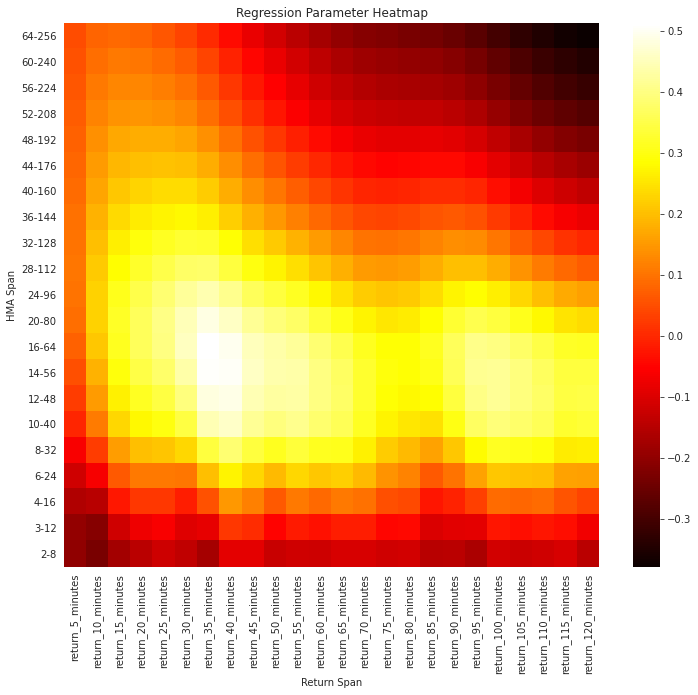

In [20]:
plt.figure(figsize=(12,10))
sns.heatmap(parameters_df.iloc[::-1], cmap="hot")
plt.title("Regression Parameter Heatmap")
plt.xlabel('Return Span')
plt.ylabel('HMA Span')

plt.show()

In [21]:
maxp_return_window = parameters_df.max().idxmax()
maxp_ma_window = parameters_df.idxmax()[maxp_return_window]
print("Max parameter ma window:", maxp_ma_window, "\nMax parameter return window:", maxp_return_window)

Max parameter ma window: 16-64 
Max parameter return window: return_35_minutes


In [22]:
# r_squares
r_squares_df = pd.DataFrame.from_records(r_squares, index = window_index)
r_squares_df.columns = times
# print('R-Squared')
# r_squares_df

In [23]:
# Residule plot for 16-64 with 35 minute return
short_ma_period = window_index_to_window[maxp_ma_window][0]
long_ma_period = window_index_to_window[maxp_ma_window][1]
calculate_momentum(data, short_ma_period, long_ma_period)
X2 = sm.add_constant(data['momentum'])
est = sm.OLS(data[maxp_return_window], X2 , missing='drop')

print(data[maxp_return_window].shape)
print(X2.shape)
results = est.fit()

parameter = results.params['momentum']
r_square = results.rsquared
print(parameter, r_square)

(132990,)
(132990, 2)
0.5130212584666408 0.0021610519163507425


We do not have strong evidence that the errors follow an AR(1) process but we continue:
https://www.statsmodels.org/stable/examples/notebooks/generated/gls.html

In [24]:
ols_resid = results.resid
resid_fit = sm.OLS(ols_resid[1:].to_numpy(), sm.add_constant(ols_resid[:-1]).to_numpy(), missing='drop').fit()
print(resid_fit.tvalues[1])
print(resid_fit.pvalues[1])

1383.1825973530215
0.0


iterative_fit(1) for AR(1) process?

In [25]:
glsar_model = sm.GLSAR(data[maxp_return_window], X2, 1, missing='drop')
glsar_results = glsar_model.iterative_fit(1)
print(glsar_results.summary())

                           GLSAR Regression Results                           
Dep. Variable:      return_35_minutes   R-squared:                       0.002
Model:                          GLSAR   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     288.0
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           1.57e-64
Time:                        21:17:26   Log-Likelihood:            -5.0788e+05
No. Observations:              132989   AIC:                         1.016e+06
Df Residuals:                  132987   BIC:                         1.016e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1820      0.030      6.021      0.0

In [26]:
print("OLS parameters")
print(results.params)
print("Feasible GLS parameters")
print(glsar_results.params)
print("OLS standard errors")
print(results.bse)
print("Feasible GLS standard errors")
print(glsar_results.bse)

OLS parameters
const       0.182061
momentum    0.513021
dtype: float64
Feasible GLS parameters
const       0.182025
momentum    0.513021
dtype: float64
OLS standard errors
const       0.030229
momentum    0.030229
dtype: float64
Feasible GLS standard errors
const       0.030229
momentum    0.030229
dtype: float64


Plot residule

Residule plot for 16-64 momentum predicting return_35_minutes


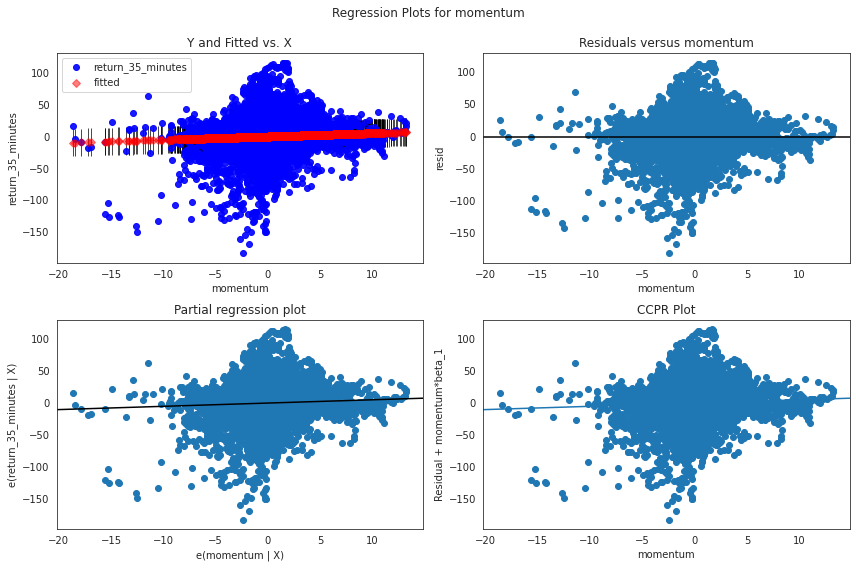

In [27]:
#define figure size
print("Residule plot for {ma_window} momentum predicting {return_window}".format(ma_window = maxp_ma_window, return_window = maxp_return_window))
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(results, 'momentum', fig=fig)

Reference: https://towardsdatascience.com/heteroscedasticity-is-nothing-to-be-afraid-of-730dd3f7ca1f

In [28]:
expr = maxp_return_window + ' ~ momentum'
y, X = dmatrices(expr, data, return_type='dataframe')

In [29]:
keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results = het_white(results.resid, X)
lzip(keys, results)

[('Lagrange Multiplier statistic:', 3051.6507343549893),
 ("LM test's p-value:", 0.0),
 ('F-statistic:', 1561.6247185809264),
 ("F-test's p-value:", 0.0)]

In [30]:
def draw_all():
    for filename in filename_2019:
        print(filename)
        data = pd.read_csv(filename, index_col=0, encoding='gbk')

        data.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open interest']
        data.rename_axis("type", axis='index', inplace=True)
        data['time'] = pd.to_datetime(data['time'])

        data.reset_index(inplace=True)
        calculate_future_return(data)

        parameters = []
        r_squares = []
        for i in range(len(short_period)):
            calculate_momentum(data, short_period[i], long_period[i])
            current_window_parameter = []
            current_window_r_square = []
            for j in range(len(times)):
                parameter, r_square = linear_regression_parameters_of_momentum(data, times[j])
                current_window_parameter.append(parameter)
                current_window_r_square.append(r_square)
            parameters.append(current_window_parameter)
            r_squares.append(current_window_r_square)

        # parameters
        parameters_df = pd.DataFrame.from_records(parameters, index = window_index)
        parameters_df.columns = times

        sns.heatmap(parameters_df, vmin=-0.5, vmax=0.5, cmap="hot")
        plt.show()

        max_return_window = parameters_df.max().idxmax()
        max_ma_window = parameters_df.idxmax()[max_return_window]
        print("Max ma window:", max_ma_window, "\nMax return window:", max_return_window)

        # Residule plot for 16-64 with thirty minute return
        short_ma_period = window_index_to_window[maxp_ma_window][0]
        long_ma_period = window_index_to_window[maxp_ma_window][1]
        calculate_momentum(data, short_ma_period, long_ma_period)
        X2 = sm.add_constant(data['momentum'])
        est = sm.OLS(data[maxp_return_window], X2, missing='drop')

        results = est.fit()

        parameter = results.params['momentum']
        r_square = results.rsquared
        # print(parameter, r_square)

        expr = maxp_return_window + ' ~ momentum'
        y, X = dmatrices(expr, data, return_type='dataframe')

        keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
        results = het_white(results.resid, X)
        print(lzip(keys, results))

## We use GLS when drawing heatmap

In [31]:
def linear_regression_parameters_of_momentum(data, time = 'one_minute_return'):
    X2 = sm.add_constant(data['momentum'])
    glsar_model = sm.GLSAR(data[time], X2, 1, missing='drop')
    glsar_results = glsar_model.iterative_fit(1)
    # print(results.summary())
    parameter = glsar_results.params['momentum']
    r_square = glsar_results.rsquared
    t_value = glsar_results.tvalues['momentum']
    
    return parameter, r_square, t_value

In [32]:
def draw_heatmap(filename):
    print(filename)
    data = pd.read_csv(filename, index_col=0, encoding='gbk')

    data.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open interest']
    data.rename_axis("type", axis='index', inplace=True)
    data['time'] = pd.to_datetime(data['time'])

    data.reset_index(inplace=True)
    calculate_future_return(data)

    parameters = []
    r_squares = []
    t_values = []
    for i in range(len(short_period)):
        calculate_momentum(data, short_period[i], long_period[i])
        current_window_parameter = []
        current_window_r_square = []
        current_window_t_value = []
        for j in range(len(times)):
            parameter, r_square, t_value = linear_regression_parameters_of_momentum(data, times[j])
            current_window_parameter.append(parameter)
            current_window_r_square.append(r_square)
            current_window_t_value.append(t_value)
        parameters.append(current_window_parameter)
        r_squares.append(current_window_r_square)
        t_values.append(current_window_t_value)

    # parameters
    parameters_df = pd.DataFrame.from_records(parameters, index = window_index)
    parameters_df.columns = times
    
    # plt.figure(figsize=(12,10))
    sns.heatmap(parameters_df.iloc[::-1], vmin=-0.5, vmax=0.5, cmap="hot")
    plt.title("Regression Parameter Heatmap")
    plt.xlabel('Return Span')
    plt.ylabel('HMA Span')
    plt.show()
    
    # r-square
    r_squares_df = pd.DataFrame.from_records(r_squares, index = window_index)
    r_squares_df.columns = times

    # plt.figure(figsize=(12,10))
    sns.heatmap(r_squares_df.iloc[::-1], cmap="hot")
    plt.title("Regression R-Square Heatmap")
    plt.xlabel('Return Span')
    plt.ylabel('HMA Span')
    plt.show()
    
    # r-square
    t_values_df = pd.DataFrame.from_records(t_values, index = window_index)
    t_values_df.columns = times

    # plt.figure(figsize=(12,10))
    sns.heatmap(t_values_df.iloc[::-1], cmap="hot")
    plt.title("Regression t-statistic Heatmap")
    plt.xlabel('Return Span')
    plt.ylabel('HMA Span')
    plt.show()
    
    max_return_window = parameters_df.max().idxmax()
    max_ma_window = parameters_df.idxmax()[max_return_window]
    print("Max ma window:", max_ma_window, "\nMax return window:", max_return_window)

../data/2019/agm.csv


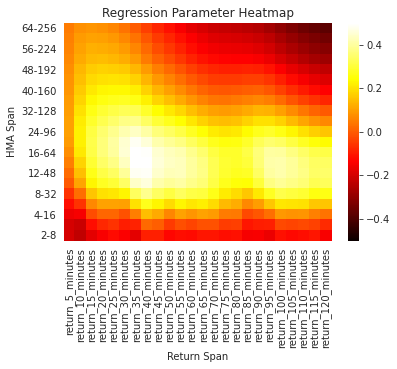

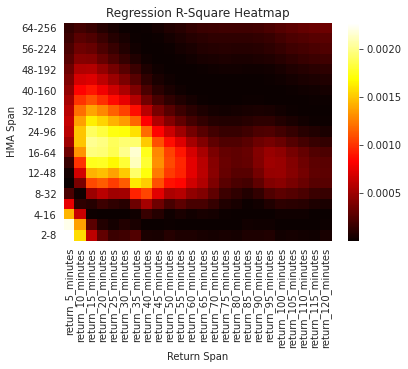

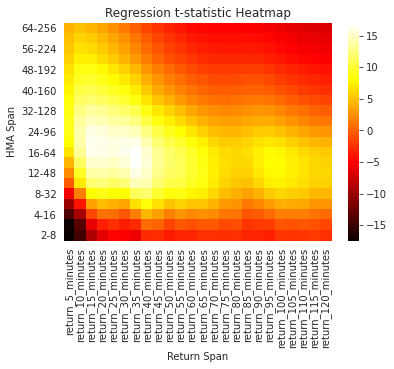

Max ma window: 16-64 
Max return window: return_35_minutes


In [33]:
# subplots
draw_heatmap(filename_2019[0])

../data/2019/alm.csv


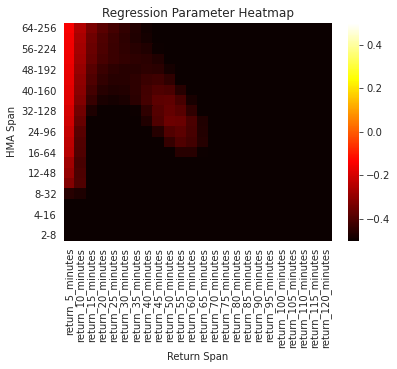

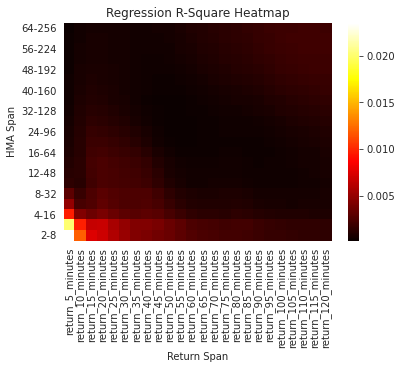

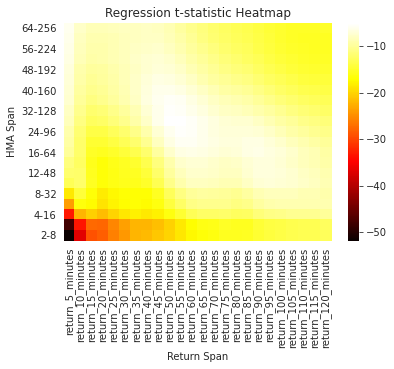

Max ma window: 64-256 
Max return window: return_5_minutes


In [34]:
draw_heatmap(filename_2019[1])

../data/2019/bum.csv


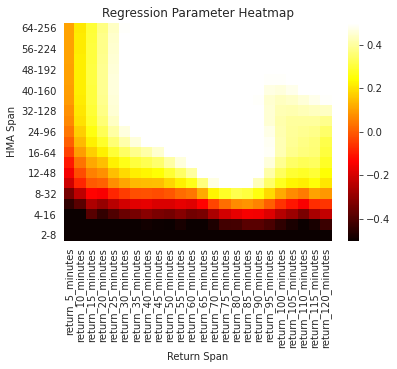

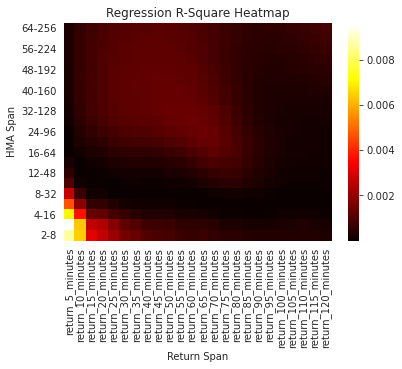

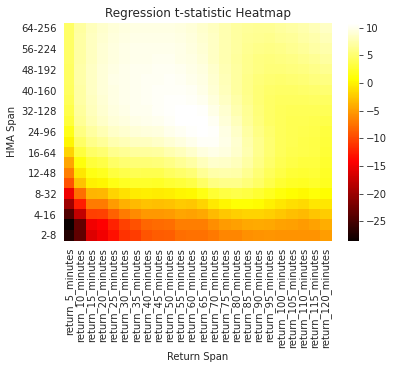

Max ma window: 64-256 
Max return window: return_120_minutes


In [35]:
draw_heatmap(filename_2019[2])

../data/2019/cfm.csv


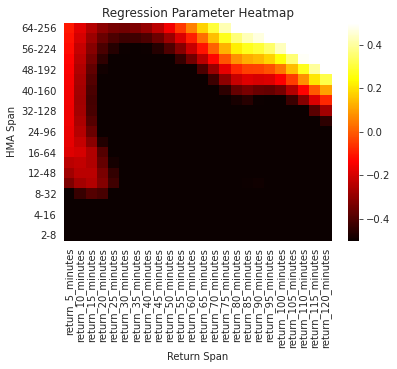

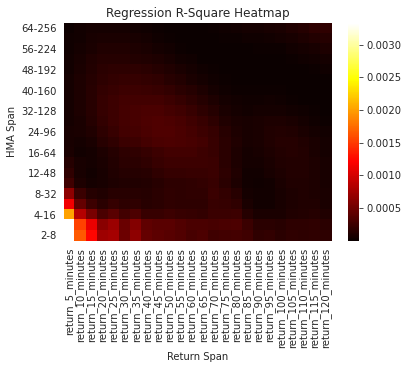

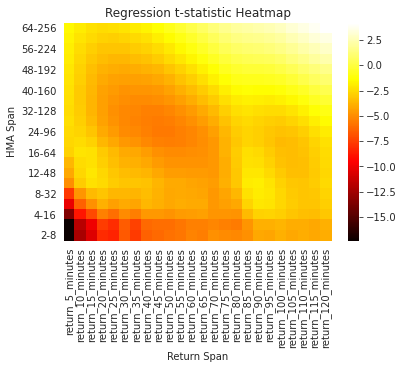

Max ma window: 64-256 
Max return window: return_120_minutes


In [36]:
draw_heatmap(filename_2019[3])

../data/2019/cum.csv


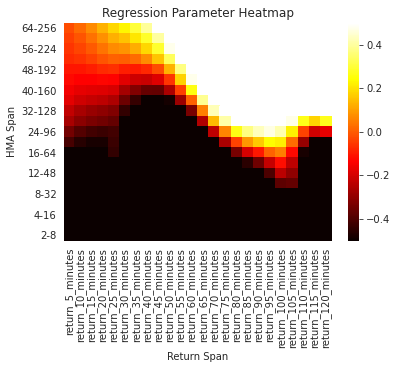

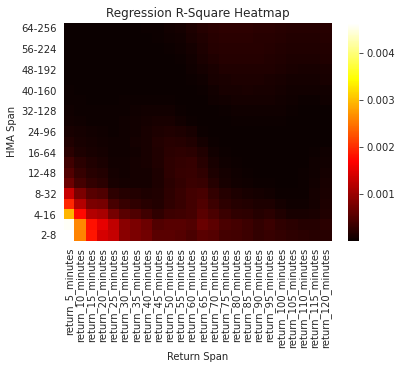

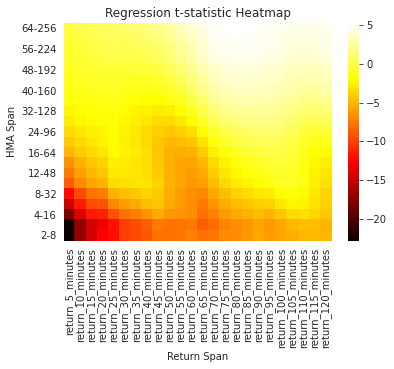

Max ma window: 64-256 
Max return window: return_120_minutes


In [37]:
draw_heatmap(filename_2019[4])

../data/2019/ebm.csv


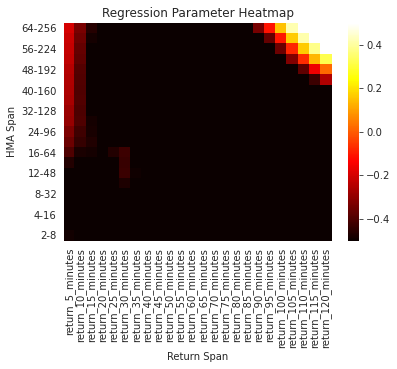

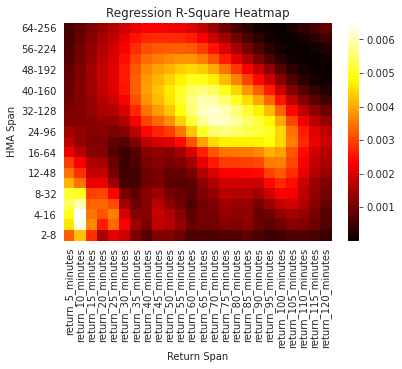

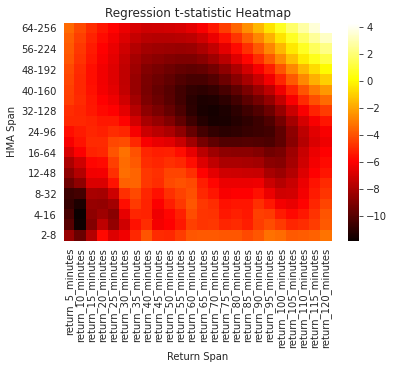

Max ma window: 64-256 
Max return window: return_120_minutes


In [38]:
draw_heatmap(filename_2019[5])

../data/2019/egm.csv


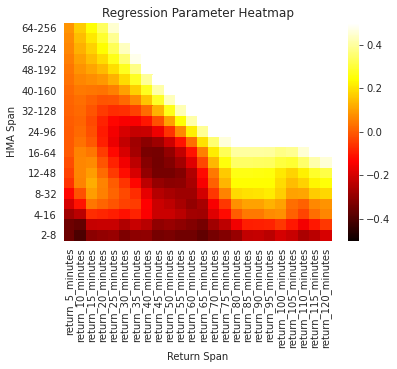

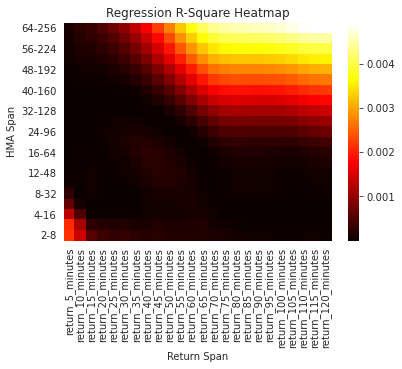

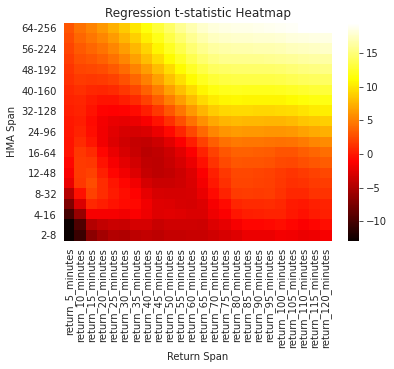

Max ma window: 64-256 
Max return window: return_120_minutes


In [39]:
draw_heatmap(filename_2019[6])

../data/2019/hcm.csv


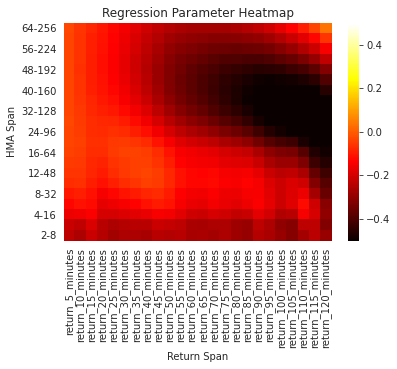

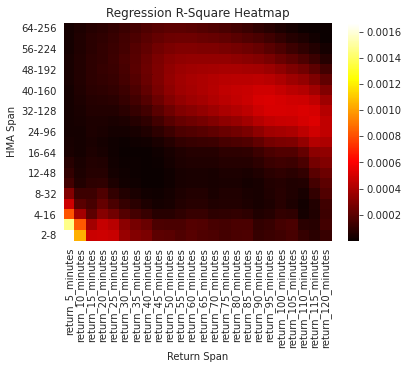

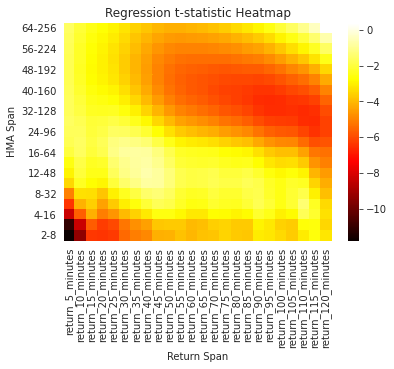

Max ma window: 64-256 
Max return window: return_120_minutes


In [40]:
draw_heatmap(filename_2019[7])

../data/2019/im.csv


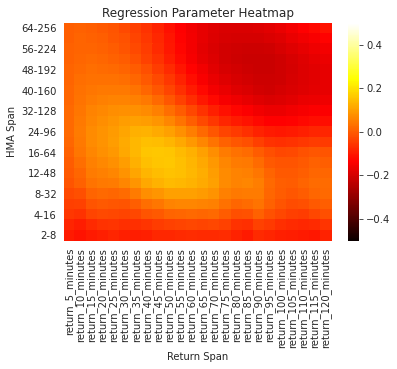

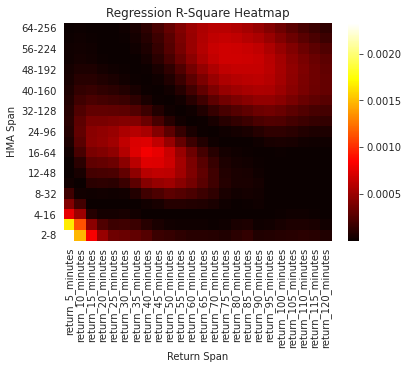

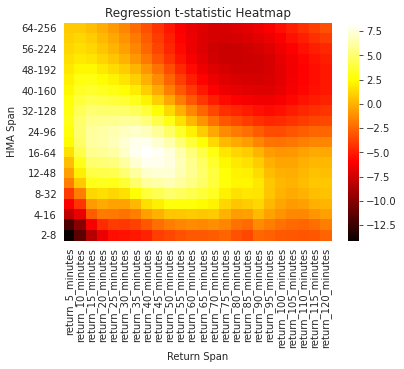

Max ma window: 16-64 
Max return window: return_45_minutes


In [41]:
draw_heatmap(filename_2019[8])

../data/2019/jm.csv


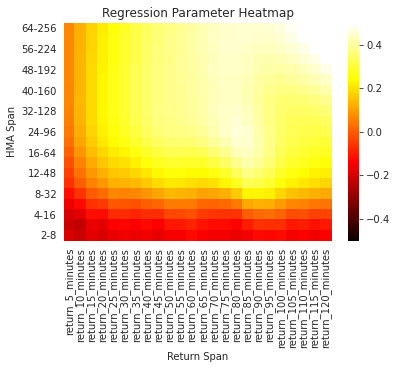

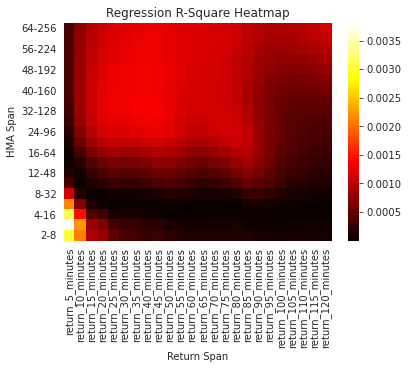

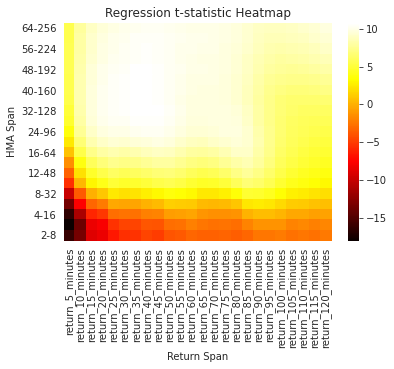

Max ma window: 64-256 
Max return window: return_120_minutes


In [42]:
draw_heatmap(filename_2019[9])

../data/2019/jmm.csv


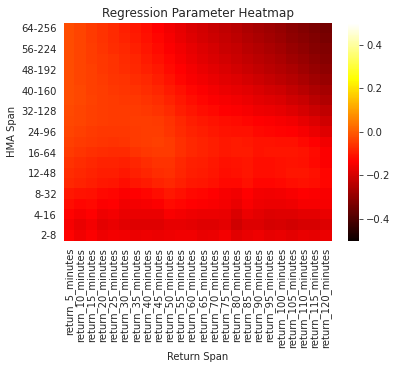

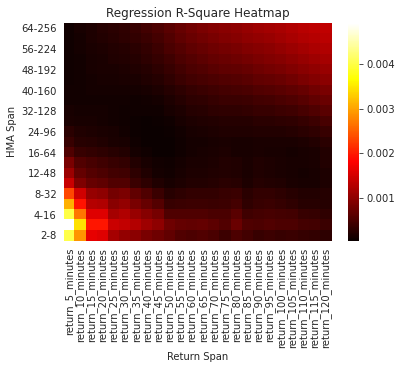

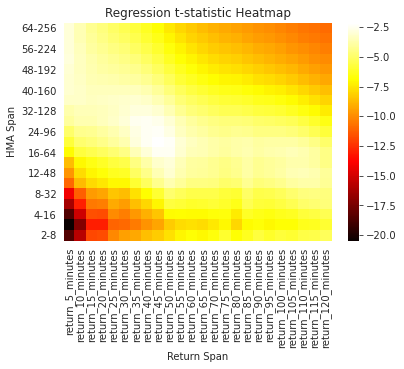

Max ma window: 52-208 
Max return window: return_5_minutes


In [43]:
draw_heatmap(filename_2019[10])